<a href="https://colab.research.google.com/github/kusawokoshitemori/MachineLearningPractice/blob/main/MachineLearningPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


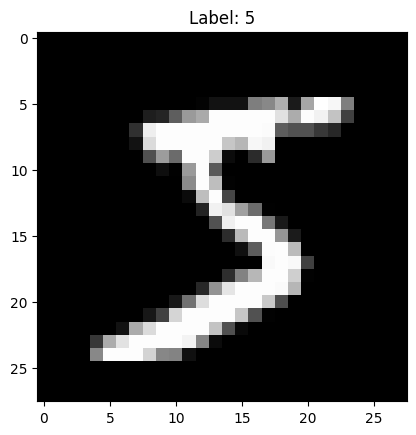

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# MNISTデータを取得
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 画像を表示
plt.imshow(train_images[0], cmap="gray")
plt.title(f"Label: {train_labels[0]}")
plt.show()


In [3]:
# 画像データを0〜1に正規化 MLP使う場合
# train_images = train_images / 255.0
# test_images = test_images / 255.0

# 画像データを0〜1に正規化 CNN使用する場合(白黒画像だから1)
train_images = train_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0


print("Normalized data:", train_images[0])


Normalized data: [[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - accuracy: 0.8890 - loss: 0.3450 - val_accuracy: 0.9853 - val_loss: 0.0449
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.9851 - loss: 0.0491 - val_accuracy: 0.9904 - val_loss: 0.0316
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 85s 35ms/step - accuracy: 0.9894 - loss: 0.0332 - val_accuracy: 0.9892 - val_loss: 0.0329
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 33ms/step - accuracy: 0.9912 - loss: 0.0263 - val_accuracy: 0.9921 - val_loss: 0.0289
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - accuracy: 0.9948 - loss: 0.0184 - val_accuracy: 0.9925 - val_loss: 0.0274
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.9945 - loss: 0.0179 - val_accuracy: 0.9907 - val_loss: 0.0328
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.9955 - loss: 0.0145 - val_accuracy: 0.9931 - val_loss: 0.0279
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.9959 -

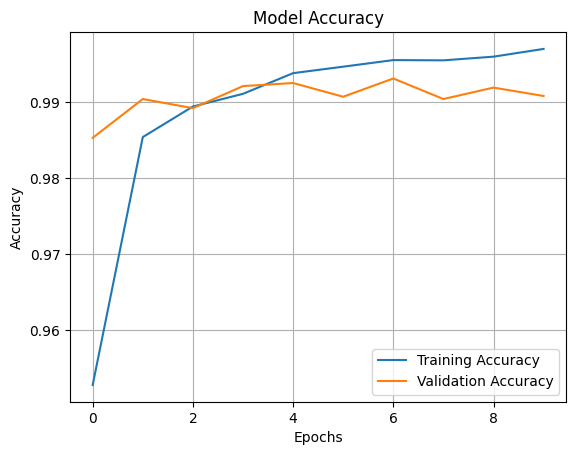

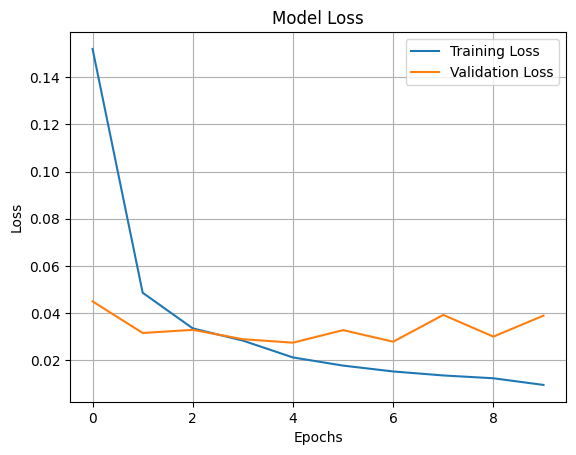

In [9]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# CNN モデル 0.9925
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  # 畳み込み層1（フィルタ32, 3x3）
    layers.MaxPooling2D((2, 2)),  # プーリング層1（2x2）

    layers.Conv2D(64, (3, 3), activation='relu'),  # 畳み込み層2（フィルタ64, 3x3）
    layers.MaxPooling2D((2, 2)),  # プーリング層2（2x2）

    layers.Conv2D(128, (3, 3), activation='relu'),  # 畳み込み層3（フィルタ128, 3x3）
    layers.Flatten(),  # 1次元化

    layers.Dense(128, activation='relu'),  # 全結合層
    layers.Dropout(0.3),  # 過学習防止のためのドロップアウト
    layers.Dense(10, activation='softmax')  # 出力層（10 クラス分類）
])

# 複雑なMLPモデル 0.9824
# model = models.Sequential([
#     layers.Flatten(input_shape=(28, 28)),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.2),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.2),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.2),
#     layers.Dense(10, activation='softmax')
# ])

# 単純なMLPモデル 0.9781
# model = models.Sequential([
#     layers.Flatten(input_shape=(28, 28)),  # 28x28 の画像を 1 次元に変換
#     layers.Dense(128, activation='relu'),  # 隠れ層1
#     layers.Dense(10, activation='softmax') # 出力層（10 クラス分類）
# ])

# アーリーストッピングの設定
early_stopping = EarlyStopping(
    monitor='val_loss',   # 監視対象（'val_loss' or 'val_accuracy'）
    patience=5,           # 5エポック改善しなかったらストップ
    restore_best_weights=True  # 最も良い重みを復元
)

# モデルのコンパイル
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# モデルの学習
hist = model.fit(train_images, train_labels,
                 epochs=50,
                 validation_data=(test_images, test_labels),
                 callbacks=[early_stopping])

# === 学習の可視化 ===
# 正解率の推移をプロット
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# 損失の推移をプロット
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [5]:
import numpy as np

# 学習後、最初の1つのデータに対して予測
predictions = model(train_images[:3]).numpy()

# ソフトマックスで確率に変換
probabilities = tf.nn.softmax(predictions)

# 確率をNumPy配列に変換
probabilities_np = probabilities.numpy()

# NumPyでの表示設定を変更
np.set_printoptions(precision=3, suppress=True)

# 確率を表示
print(probabilities_np)

print(train_labels[:3])

[[0.085 0.085 0.085 0.085 0.085 0.232 0.085 0.085 0.085 0.085]
 [0.232 0.085 0.085 0.085 0.085 0.085 0.085 0.085 0.085 0.085]
 [0.085 0.085 0.085 0.085 0.232 0.085 0.085 0.085 0.085 0.085]]
[5 0 4]


In [6]:
import numpy as np

# 学習後、最初の1つのデータに対して予測
predictions = model(test_images[:3]).numpy()

# ソフトマックスで確率に変換
probabilities = tf.nn.softmax(predictions)

# 確率をNumPy配列に変換
probabilities_np = probabilities.numpy()

# NumPyでの表示設定を変更
np.set_printoptions(precision=3, suppress=True)

# 確率を表示
print(probabilities_np)

print(test_labels[:3])

[[0.085 0.085 0.085 0.085 0.085 0.085 0.085 0.232 0.085 0.085]
 [0.085 0.085 0.232 0.085 0.085 0.085 0.085 0.085 0.085 0.085]
 [0.085 0.232 0.085 0.085 0.085 0.085 0.085 0.085 0.085 0.085]]
[7 2 1]


In [10]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test accuracy:", test_acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9906 - loss: 0.0347
Test accuracy: 0.9925000071525574
